I will be working with the [Kaggle Diabetes Data Set](https://www.kaggle.com/datasets/vikasukani/diabetes-data-set) stored in `diabetes-dataset.csv`. The following attributes are provided:

*Attribute Information:* (Outcome: no diabetes=0, diabetes=1)

1. Pregnancies
2. Glucose(sugar)
3. BloodPressure
4. SkinThickness
5. Insulin
6. BMI(Inclusion-body myositis (IBM) primarily affects men)
7. DiabetesPedigreeFunction(DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes based on family)
8. Age


In [1]:
#Import libraries
import numpy as np
import scipy.optimize as opt
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

# Load Data from CSV File

In [2]:
df_diabetes = pd.read_csv("diabetes-dataset.csv" , delimiter=",")
df_diabetes[0:8]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
5,0,173,78,32,265,46.5,1.159,58,0
6,4,99,72,17,0,25.6,0.294,28,0
7,8,194,80,0,0,26.1,0.551,67,0


There are 2000 records in dataframe.

In [3]:
df_diabetes.shape

(2000, 9)

# Using `isnull()` in the following cell, we can determine if DataFrame has any NaN values.

In [4]:
df_diabetes.isnull().any().any()

False

#### There is no NaN

# Descriptive statistics:

In [5]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


# To determine which features have a great impact on Outcome, I use Seaborn `heatmap()`.

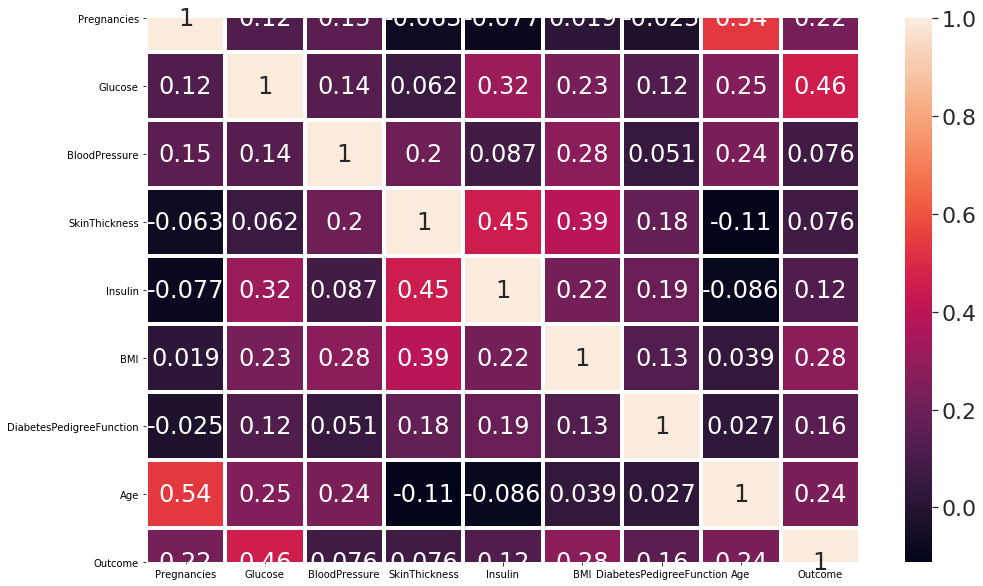

In [6]:
fig, ax = plt.subplots(figsize=(16,10))  
sns.set(font_scale=2.0)
sns.heatmap(df_diabetes.corr() , annot= True, linewidths=3, ax=ax)

## Outcome is greatly influenced by:
### 1. Glucose(0.46) 
### 2. BMI(0.28) 
### 3. Age(0.24)
### 4. Pregnancies(0.22)
### 5. DiabetesPedigreeFunction(0.16)
### 6. Insulin(0.12)
### 7. BloodPressure & SkinThickness (0.076)

### In order to visualize this relationship, I would like to visualize the three most influential features and the Outcome.

### Data Visualization and Analysis:

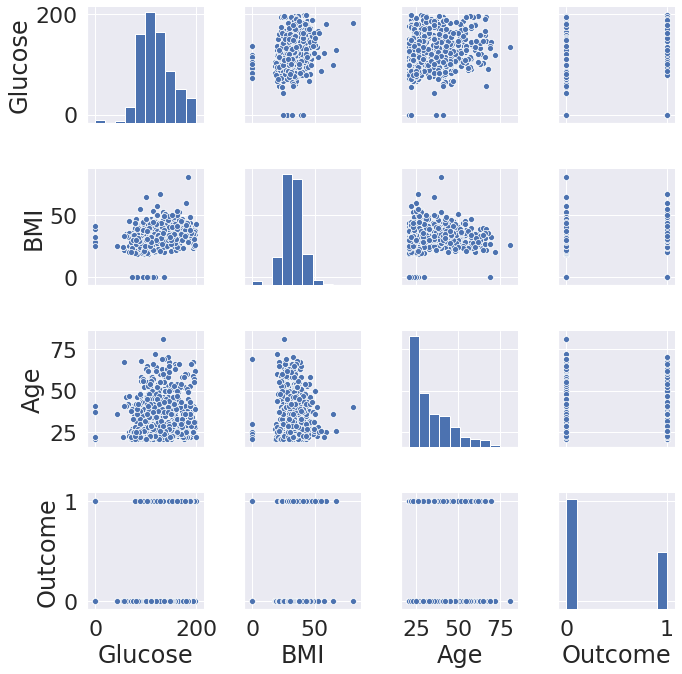

In [7]:
cdf = df_diabetes[['Glucose', 'BMI', 'Age', 'Outcome']] 
sns.set(font_scale=2.0)
sns.pairplot(cdf)

## Boxplots and outliers

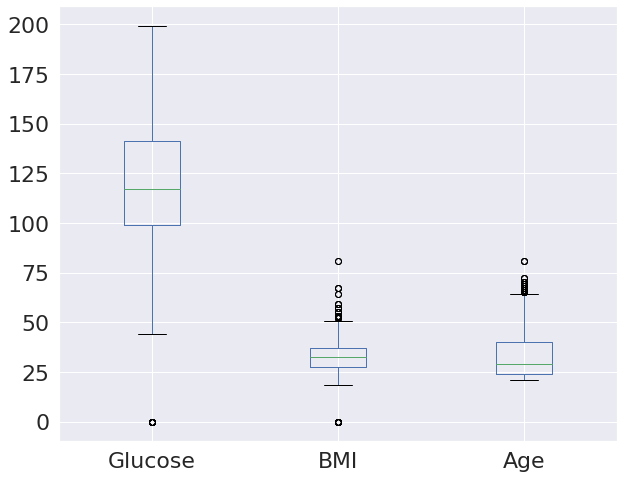

In [8]:
plt.figure(figsize=(10, 8))
boxplot = df_diabetes.boxplot(column=['Glucose', 'BMI', 'Age']) 

# Split the DataFrame into X (the data) and y (the labels), where:

In [9]:
X = df_diabetes[['Glucose', 'BMI', 'Age']]      
y = df_diabetes['Outcome'] # label

# LogisticRegression

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
#By default, cross_val_score performs three-fold cross-validation, returning three accuracy values. I change the number of folds
#used by changing the cv parameter.
scores = cross_val_score(logreg, X, y, cv=10)
print("cross-validation scores: ", scores)
print('Mean of cross-validation accuracy: {:.2f}' .format(scores.mean()))

cross-validation scores:  [0.76119403 0.73134328 0.76616915 0.78606965 0.77       0.815
 0.77386935 0.65829146 0.81407035 0.7839196 ]
Mean of cross-validation accuracy: 0.77


Looking at the scores for the Diabetes dataset above, I see accuracies between 66% and 82%. This is quite a range, and provides me with an idea about how the model might perform in the worst case and the best case scenarios when applied to new data. But, the main disadvantage of cross-validation is increased computational cost. As I am now training 10 models, instead of a single model, cross-validation will be roughly 10 times slower than doing a single split of the data.

# Using train_test_split, split X and y into training and test sets

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVC

## Grid-search with cross-validation

For SVM with an RBF (radial basis function) kernel, there are two important parameters: the kernel bandwidth gamma and the regularization parameter C. I want to try values 0.001, 0.01, 0.1, 1, 10 and 100 for the parameter C, and the same for gamma. Because I have six different settings for C and gamma that I want to try, I have 36 combinations of parameters in total. 

In [12]:
from sklearn.svm import SVC
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_train, y_train, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Model Accuracy

In [13]:
print('Accuracy of SVC on train set: {:.2f}' .format(svm.score(X_train, y_train)))
print('Accuracy of SVC on test set: {:.2f}' .format(svm.score(X_test, y_test)))

Accuracy of SVC on train set: 1.00
Accuracy of SVC on test set: 0.96


### I predicted the correct class on 96% of the samples in X_test. 

## For SVC & LogisticRegression, I create a `Precision-Recall_Curve ` and a `ROC_Curve ` using y_test. 

#### Below I compare the SVC I trained to a LogisticRegression trained on the same dataset.

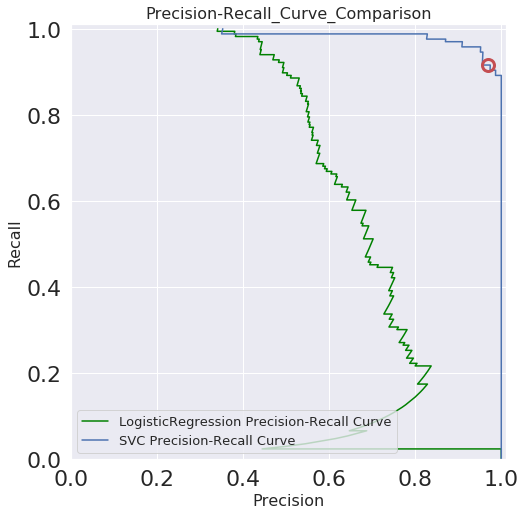

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_scores_logreg = logreg.decision_function(X_test)
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, y_scores_logreg)

closest_zero_logreg = np.argmin(np.abs(thresholds_logreg))
closest_zero_p_logreg = precision_logreg[closest_zero_logreg]
closest_zero_r_logreg = recall_logreg[closest_zero_logreg]

y_scores = svm.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(12, 8))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision_logreg, recall_logreg, color='green', label='LogisticRegression Precision-Recall Curve')
plt.plot(precision, recall, label='SVC Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle ='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.title('Precision-Recall_Curve_Comparison', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.axes().set_aspect('equal')
plt.show()

#### The closer a curve stays to the upper right corner, the better the classifier. A point at the upper right means high precision and high recall for the same threshold.

### Comparing LogisticRegression and SVC using the AUC score, I find that SVC performs quite a much better than LogisticRegression.

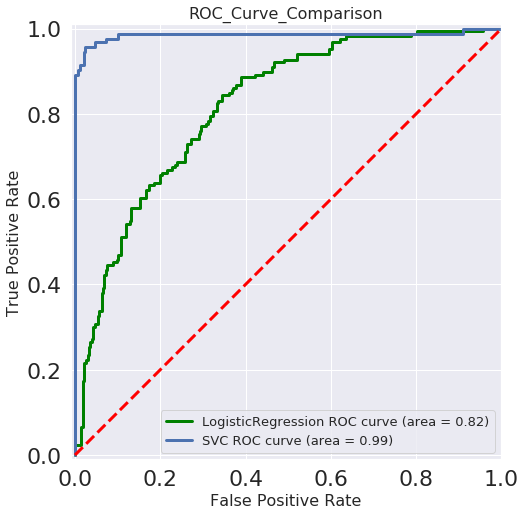

In [15]:
fpr_lr_logreg, tpr_lr_logreg, _ = roc_curve(y_test, y_scores_logreg)
roc_auc_lr_logreg = auc(fpr_lr_logreg, tpr_lr_logreg)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(12, 8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_logreg, tpr_lr_logreg, lw=3, color='green', label='LogisticRegression ROC curve (area = {:0.2f})'.format(roc_auc_lr_logreg))
plt.plot(fpr_lr, tpr_lr, lw=3, label='SVC ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC_Curve_Comparison', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

#### For the ROC curve, the ideal curve is close to the top left: I want a classifier that produces a high recall while keeping a low false positive rate.

# DecisionTreeClassifier

### Using `X_train` and `y_train`, train a `DecisionTreeClassifier` with default parameters and random_state=0. 

In [16]:
DTClf = DecisionTreeClassifier(random_state = 0)  #DTClf = Decision Tree Classifier
DTClf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [17]:
Model_Prediction = DTClf.predict(X_test)

### In order to show easily the differences between model-based prediction and real values, I create a dataframe.

In [18]:
d = {'real or true values(y_test)': y_test, 'Model_Prediction': Model_Prediction}
dfC = pd.DataFrame(data=d)
dfC.head(10)

,real or true values(y_test),Model_Prediction
405,0,0
1190,0,0
1132,1,1
731,1,1
1754,1,1
1178,0,0
1533,0,0
1303,0,0
1857,0,0
18,0,0


### Model Accuracy

In [19]:
print('Accuracy of Decision Tree classifier on train set: {:.2f}' .format(DTClf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(DTClf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on train set: 1.00
Accuracy of Decision Tree classifier on test set: 0.97


### Using this model, 97% of diabetes can be distinguished. My accuracy improved by 1%

# KNeighborsClassifier 


### Using `X_train` and `y_train`, train a `KNeighborsClassifier ` with default parameters and n_neighbors=1. 

In [20]:
from sklearn.neighbors import KNeighborsClassifier
KNClf = KNeighborsClassifier(n_neighbors = 1)  # KNClf= KNeighborsClassifier
KNClf.fit(X_train_scaled, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Model prediction

In [21]:
Model_Prediction_knn = KNClf.predict(X_test_scaled)
Model_Prediction_knn

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Model Accuracy

In [22]:
print('Accuracy of KNeighborsClassifier on train set: {:.2f}' .format(KNClf.score(X_train_scaled, y_train)))
print('Accuracy of KNeighborsClassifier on test set: {:.2f}' .format(KNClf.score(X_test_scaled, y_test)))

Accuracy of KNeighborsClassifier on train set: 1.00
Accuracy of KNeighborsClassifier on test set: 0.97


### Using this model, 97% of diabetes can be distinguished. 

### Is `n_neighbors = 1 ` the best value? Yes, because:

In [23]:
from sklearn import metrics
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_scaled, y_train)
    yhat = neigh.predict(X_test_scaled)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
mean_acc

array([0.974, 0.9  , 0.844, 0.812, 0.824, 0.796, 0.808, 0.808, 0.82 ,
       0.814, 0.806, 0.792, 0.802, 0.806])

### To better understand, I visualize previous cell to see better the relationship between `Accuracy ` and `Number of Neighbors(K)`.

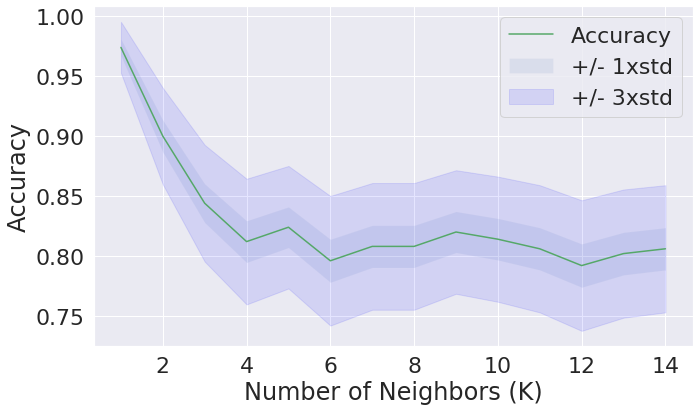

In [24]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks), mean_acc - 3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color='blue')
plt.legend(('Accuracy', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [25]:
print("The best accuracy is {:.2f}" .format(mean_acc.max()), "with k =", mean_acc.argmax()+ 1)

The best accuracy is 0.97 with k = 1


### confusion_matrix

In [26]:
from sklearn.metrics import classification_report, confusion_matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i , j] , fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Outcome')
    plt.xlabel('Predicted Outcome')

Confusion matrix, without normalization
[[159   7]
 [  6 328]]


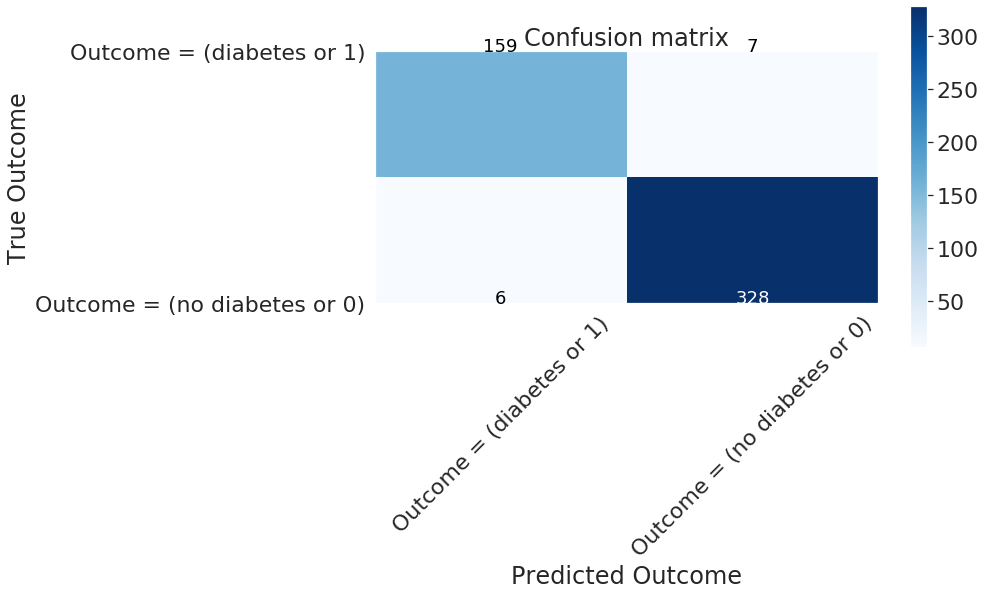

In [27]:
cnf_matrix = confusion_matrix(y_test, Model_Prediction_knn, labels=[1,0])
np.set_printoptions(precision=3)

plt.figure(figsize=(14, 8))
plt.grid(False)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cnf_matrix, classes=['Outcome = (diabetes or 1)', 'Outcome = (no diabetes or 0)'], normalize = False)

In [28]:
print(classification_report(y_test, Model_Prediction_knn))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       334
           1       0.96      0.96      0.96       166

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

